In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import ExponentialSmoothing
from math import sqrt
from sklearn.metrics import mean_squared_error

# Data Loading and pre-processing

In [2]:
# Loading dataset

df_total = pd.read_csv("/home/exalis/Téléchargements/Simple_Dataset_2020_01_27 & Station.csv")

In [3]:
df_total.head()

,Unnamed: 0,availiable_docks,date,station_name
0,0,33,2020-01-15 10:17:00,Benjamin Godard - Victor Hugo
1,1,53,2020-01-15 10:17:00,André Mazet - Saint-André des Arts
2,2,19,2020-01-15 10:17:00,Toudouze - Clauzel
3,3,19,2020-01-15 10:17:00,Charonne - Robert et Sonia Delauney
4,4,27,2020-01-15 10:17:00,Mairie du 12ème


In [4]:
# Taking only station "Godot de Mauroy - Madeleine"
df_case = df_total[df_total["station_name"]=="Godot de Mauroy - Madeleine"]

In [5]:
df_case.head()

,Unnamed: 0,availiable_docks,date,station_name
979,979,8,2020-01-15 10:17:00,Godot de Mauroy - Madeleine
2372,2372,8,2020-01-15 10:18:00,Godot de Mauroy - Madeleine
3765,3765,7,2020-01-15 10:19:00,Godot de Mauroy - Madeleine
5158,5158,8,2020-01-15 10:20:00,Godot de Mauroy - Madeleine
6551,6551,8,2020-01-15 10:21:00,Godot de Mauroy - Madeleine


In [6]:
df_case["hour"] = df_case["date"].apply(lambda x: pd.Timestamp(x).hour)

/home/exalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:
#df_morning = df_case[df_case["hour"]==8].append(df_case[df_case["hour"]==9])
df_morning = df_case[df_case["hour"]==18]
df_morning=df_morning.sort_values(by="date")

In [8]:
df_morning.head()

,Unnamed: 0,availiable_docks,date,station_name,hour
645150,645150,10,2020-01-15 18:00:00,Godot de Mauroy - Madeleine,18
646543,646543,10,2020-01-15 18:01:00,Godot de Mauroy - Madeleine,18
647936,647936,10,2020-01-15 18:02:00,Godot de Mauroy - Madeleine,18
649329,649329,10,2020-01-15 18:03:00,Godot de Mauroy - Madeleine,18
650722,650722,10,2020-01-15 18:04:00,Godot de Mauroy - Madeleine,18


In [9]:
# Saving time for later
save_time = df_morning.date

In [10]:
# Removing all useless columns
dataset = np.array(df_morning["availiable_docks"])

In [11]:
dataset[0:10]

array([10, 10, 10, 10, 10, 10, 10,  9, 10,  9])

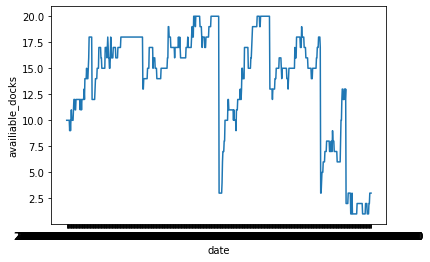

In [12]:
_ = sns.lineplot(data=df_morning,x="date", y="availiable_docks")

In [13]:
# Variable definition
split_ratio = 0.7

In [14]:
# Doing a slit of aust between train and test
train = dataset[0:int(round(len(dataset)*split_ratio,0))]
test = dataset[int(round(len(dataset)*split_ratio,0)):]

In [15]:
print("Length of dataset:", len(dataset))
print("Length of train:", len(train))
print("Length of test:", len(test))
print("Check:", len(dataset)-len(train)-len(test))

Length of dataset: 720
Length of train: 504
Length of test: 216
Check: 0


# Modelling

In [16]:
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [17]:
# OK
# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    # define config lists
    t_params = ['add','mul', None]
    d_params = [True, False]
    s_params = ['add','mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

# Creating list of configuration possible
cfg_list = exp_smoothing_configs(seasonal=[60])

In [18]:
# one-step Holt Winters Exponential Smoothing forecast
def exp_smoothing_forecast_grid_search(train, test, configurations):
    best_config = ""
    best_rmse = 99999
    for i in range(len(configurations)):
        try:
            t,d,s,p,b,r = configurations[i]
            # define model
            model = ExponentialSmoothing(train, trend=t, damped=d, seasonal=s, seasonal_periods=p).fit(optimized=True,use_boxcox=b,remove_bias=r)
            # fit model
            # make one step forecast
            pred = model.predict(start=len(train),end=len(test)+len(train)-1)
            temp_indicator = measure_rmse(test,pred)
            if temp_indicator < best_rmse:
                best_rmse = temp_indicator
                best_config = configurations[i]
        except:
            print("error")
    print(best_config)
    print(best_rmse)
    return(best_config)

In [19]:
best_parameters = exp_smoothing_forecast_grid_search(train, test, cfg_list)

/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


error


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: Converge

error
error


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:939: RuntimeWarning: invalid value encountered in double_scalars
  'initial_slope': b[0] / phi,
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


error


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


error


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:881: RuntimeWarning: invalid value encountered in power
  (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py

error


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:881: RuntimeWarning: invalid value encountered in power
  (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:884: RuntimeWarning: invalid value encountered in power
  (betac * dampen(b[i - 1], phi))
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:886: RuntimeWarning: invalid value encountered in power
  (gamma * trended(lvls[i - 1], dampen(b[i - 1], phi))) + \
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:892: RuntimeWarning: invalid value encountered in power
  b[:nobs] = dampen(b[:nobs], phi)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py

error


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:863: RuntimeWarning: invalid value encountered in power
  (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:866: RuntimeWarning: invalid value encountered in power
  (betac * dampen(b[i - 1], phi))
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:867: RuntimeWarning: invalid value encountered in power
  s[i + m - 1] = y_gamma[i - 1] / trended(lvls[i - 1], dampen(b[i - 1], phi)) + \
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:873: RuntimeWarning: invalid value encountered in power
  b[:nobs] = dampen(b[:nobs], phi)


error


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:863: RuntimeWarning: invalid value encountered in power
  (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:866: RuntimeWarning: invalid value encountered in power
  (betac * dampen(b[i - 1], phi))
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:867: RuntimeWarning: invalid value encountered in power
  s[i + m - 1] = y_gamma[i - 1] / trended(lvls[i - 1], dampen(b[i - 1], phi)) + \
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:873: RuntimeWarning: invalid value encountered in power
  b[:nobs] = dampen(b[:nobs], phi)


error


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:863: RuntimeWarning: invalid value encountered in power
  (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:866: RuntimeWarning: invalid value encountered in power
  (betac * dampen(b[i - 1], phi))
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:867: RuntimeWarning: invalid value encountered in power
  s[i + m - 1] = y_gamma[i - 1] / trended(lvls[i - 1], dampen(b[i - 1], phi)) + \
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:873: RuntimeWarning: invalid value encountered in power
  b[:nobs] = dampen(b[:nobs], phi)


error


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:939: RuntimeWarning: divide by zero encountered in double_scalars
  'initial_slope': b[0] / phi,
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:939: RuntimeWarning: divide by zero encountered in double_scalars
  'initial_slope': b[0] / phi,
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:939: RuntimeWarning: divide by zero encountered in double_scalars
  'initial_slope': b[0] / phi,
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:939: RuntimeWarning: divide by zero encountered in double_scalars
  'initial_slope': b[0] / phi,
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:881: RuntimeWarning: 

error


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:881: RuntimeWarning: overflow encountered in multiply
  (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:886: RuntimeWarning: overflow encountered in multiply
  (gamma * trended(lvls[i - 1], dampen(b[i - 1], phi))) + \
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:883: RuntimeWarning: invalid value encountered in true_divide
  b[i] = (beta * detrend(lvls[i], lvls[i - 1])) + \
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:894: RuntimeWarning: overflow encountered in multiply
  trend = trended(lvls, b)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holt

error


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


error
error
error
error
error
error
error
error
error
error
error
error
error


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: Converge

['mul', False, None, 60, True, False]
5.3245236181806535


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [20]:
best_parameters

['mul', False, None, 60, True, False]

# Best model

In [21]:
t,d,s,p,b,r = best_parameters

# define model
model = ExponentialSmoothing(train, trend=t, damped=d, seasonal=s, seasonal_periods=p).fit(optimized=True,use_boxcox=b,remove_bias=r)
# make one step forecast
pred = model.predict(start=len(train),end=(len(test)+len(train)-1))
temp_indicator = measure_rmse(test,pred)
print(temp_indicator)

5.3245236181806535


In [22]:
df = pd.DataFrame(columns=["actual","forecast"])
df.actual = (pd.DataFrame(train)).append(pd.DataFrame(test))[0]
df.forecast = (pd.DataFrame(train)).append(pd.DataFrame(pred))[0]
df = df.reset_index(drop=True)
df

,actual,forecast
0,10,10.000000
1,10,10.000000
2,10,10.000000
3,10,10.000000
4,10,10.000000
...,...,...
715,2,9.368304
716,3,9.344741
717,3,9.321238
718,3,9.297796


# Graphic visualisation

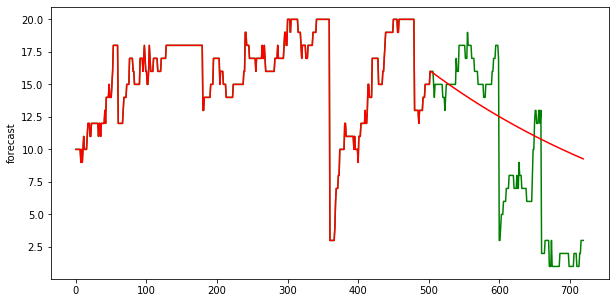

In [23]:
# Creation of a plot // Density level vs average docks

fig, axis = plt.subplots(figsize=(10,5))
sns.lineplot(x=df.index, y="actual",data=df, color="green")
sns.lineplot(x=df.index, y="forecast",data=df, color="red")

plt.show()

- utiliser le moment en semaine
- 